In [2]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os

sns.set_style("white")


In [41]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [4]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.experiment_name = experiment_name
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}, lr={}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling":
            label = "{}, {}, {}, {}, {}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}, bs={}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k, 
                                                   self.lr) 

        if self.trial:
            label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

In [53]:

def plot(xs_by_config, ys_by_config, xlabel, ylabel, plot_dir, smoothing=0, lw=1, ymin=None):
    xmax = - float("inf")
    ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):

        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]

        #TODO get label here
        label = config.label
        print xlabel, ",", ylabel, len(xs), len(ys)
        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.8)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.8)
        
        if max(xs) > xmax:
            xmax = max(xs)
        if max(ys) > ymax:
            ymax = max(ys)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plt.legend(fontsize=8)
        plt.xlim(0, xmax)
        if ymin is not None:
            plt.ylim(ymin, ymax)
        plot_file = "{}_{}_lr{}.pdf".format(config.experiment_name,
                                            ylabel,
                                            config.lr)
        plt.savefig(os.path.join(plot_dir, plot_file))
        plt.show()
        plt.clf()


In [6]:
def plot_experiments(experiment_names, experiments_dir, plot_dir, lrs=None, nets=None, trials=None, smoothing=0):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store":
                continue
            elif filename == "pickles":
                continue

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue

            train_num_backprops = [l.num_backprop for l in train_lines]
            test_num_backprops = [l.num_backprop for l in test_lines]
            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            ratio_backpropped_ys = [l.num_backprop / float(l.num_backprop + l.num_skip) \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]
            ratio_backpropped_xs = [l.num_backprop \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]


            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Trained", "Ratio Backpropped", plot_dir, smoothing, ymin=0)
    plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Trained", "Training Loss", plot_dir, smoothing, lw=0.6)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Trained", "Test Accuracy", plot_dir, smoothing, lw=0.6, ymin=0)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Trained", "Test Loss", plot_dir, smoothing, lw=0.6)

sampling_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0005_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0005_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial2_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial2_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial2_v2
Num Images Trained , Ratio Backpropped 5175 5175
Num Images Trained , Ratio Backpropped 5274 5274
Num Images Trained , Ratio Backpropped 571 571
Num Images Trained , Ratio Backpropped 320 320


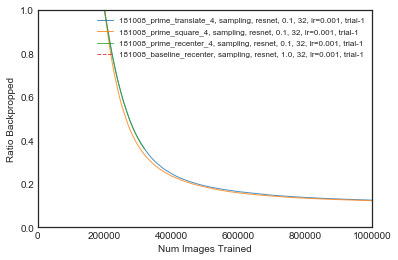

Num Images Trained , Training Loss 39931 39931
Num Images Trained , Training Loss 40569 40569
Num Images Trained , Training Loss 4966 4966
Num Images Trained , Training Loss 3139 3139


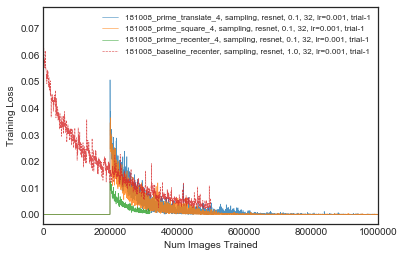

Num Images Trained , Test Accuracy 5176 5176
Num Images Trained , Test Accuracy 5275 5275
Num Images Trained , Test Accuracy 572 572
Num Images Trained , Test Accuracy 321 321


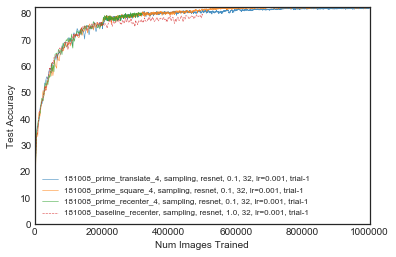

Num Images Trained , Test Loss 5176 5176
Num Images Trained , Test Loss 5275 5275
Num Images Trained , Test Loss 572 572
Num Images Trained , Test Loss 321 321


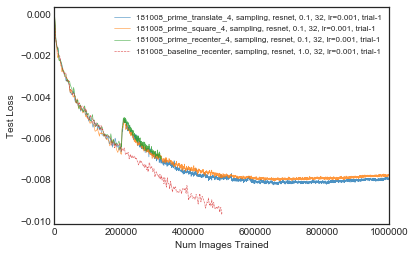

<Figure size 432x288 with 0 Axes>

In [36]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181008_batching/prime4".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["181007_baseline", "181008_baseline_recenter", "181008_recenter", "181008_translate", "181008_square"]
# plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)

# experiment_names = ["181007_baseline", "181008_baseline_recenter", "181008_prime_recenter_1", "181008_prime_recenter_2", "181008_prime_recenter_4",
#                    "181008_prime_translate_2", "181008_prime_translate_4", "181008_prime_square_2", "181008_prime_square_4"]
experiment_names = ["181008_baseline_recenter", "181008_prime_recenter_4",
                    "181008_prime_translate_4", "181008_prime_square_4"]
plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)


sampling_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial2_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial2_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0005_trial2_v2
Num Images Trained , Ratio Backpropped 11311 11311
Num Images Trained , Ratio Backpropped 12011 12011
Num Images Trained , Ratio Backpropped 15998 15998
Num Images Trained , Ratio Backpropped 5232 5232


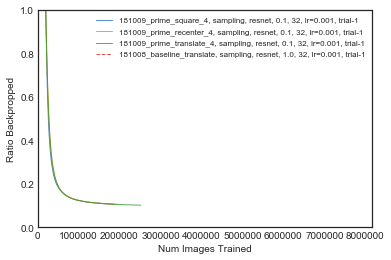

Num Images Trained , Training Loss 86022 86022
Num Images Trained , Training Loss 91227 91227
Num Images Trained , Training Loss 121316 121316
Num Images Trained , Training Loss 51192 51192


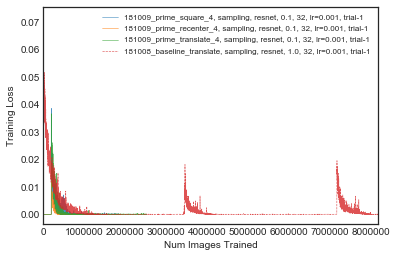

Num Images Trained , Test Accuracy 11312 11312
Num Images Trained , Test Accuracy 12012 12012
Num Images Trained , Test Accuracy 15999 15999
Num Images Trained , Test Accuracy 5233 5233


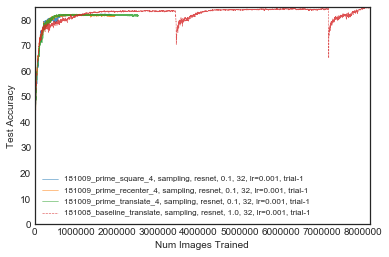

Num Images Trained , Test Loss 11312 11312
Num Images Trained , Test Loss 12012 12012
Num Images Trained , Test Loss 15999 15999
Num Images Trained , Test Loss 5233 5233


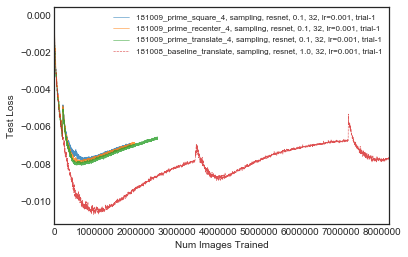

sampling_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_.4_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_.4_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
Num Images Trained , Ratio Backpropped 1407 1407
Num Images Trained , Ratio Backpropped 1428 1428
Num Images Trained , Ratio Backpropped 1260 1260
Num Images Trained , Ratio Backpropped 1269 1269
Num Images Trained , Ratio Backpropped 5232 5232


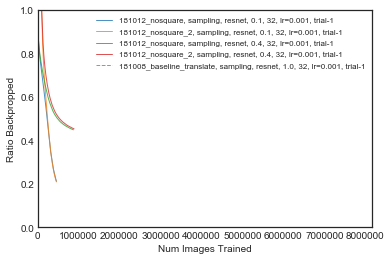

Num Images Trained , Training Loss 11492 11492
Num Images Trained , Training Loss 11664 11664
Num Images Trained , Training Loss 11084 11084
Num Images Trained , Training Loss 11220 11220
Num Images Trained , Training Loss 51192 51192


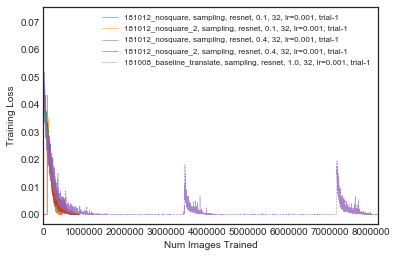

Num Images Trained , Test Accuracy 1408 1408
Num Images Trained , Test Accuracy 1429 1429
Num Images Trained , Test Accuracy 1261 1261
Num Images Trained , Test Accuracy 1270 1270
Num Images Trained , Test Accuracy 5233 5233


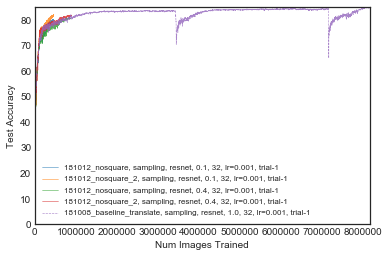

Num Images Trained , Test Loss 1408 1408
Num Images Trained , Test Loss 1429 1429
Num Images Trained , Test Loss 1261 1261
Num Images Trained , Test Loss 1270 1270
Num Images Trained , Test Loss 5233 5233


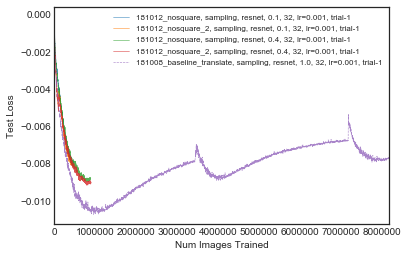

<Figure size 432x288 with 0 Axes>

In [54]:
# BATCHING

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/181008_batching/prime0".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
experiment_names = ["181008_baseline_recenter", "181008_recenter", "181008_translate", "181008_square"]
#plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)

plot_dir = "{}/181009_batching/prime4".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
experiment_names = ["181008_baseline_recenter", "181009_prime_recenter_4",
                    "181009_prime_translate_4", "181009_prime_square_4"]
#plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)

plot_dir = "{}/181009_batching/prime4_long".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
experiment_names = ["181008_baseline_translate", "181009_prime_recenter_4",
                    "181009_prime_translate_4", "181009_prime_square_4"]
plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)

plot_dir = "{}/181009_check/prime4".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
experiment_names = ["181009_check_recenter_4"]
#plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)

# NOSQUARE
plot_dir = "{}/181012_nosquare/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
experiment_names = ["181012_nosquare", "181012_nosquare_2", "181008_baseline_translate"]
plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)
